In [1]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt

train_df=pd.read_csv('../input/nlp-getting-started/train.csv')
test_df=pd.read_csv('../input/nlp-getting-started/test.csv')
sample_df=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

train_df['class']=train_df['target'].map({0:'Not disaster',1:'Disaster'})
print(train_df.shape,test_df.shape)
train_df.sample(5)
#test_df.sample(5)

(7613, 6) (3263, 4)


,id,keyword,location,text,target,class
4119,5854,hailstorm,Massachusetts,Twin Storms Blow Through Calgary ~ 1 http://t....,1,Disaster
3299,4729,evacuate,NaN,Pls can alllll the nittys evacuate stockwell,0,Not disaster
648,939,blaze,"Atlanta,Ga",Welcome @djryanwolf @djcoreygrand @djknyce @dj...,0,Not disaster
5905,8433,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1,Disaster
3828,5446,first%20responders,USA,First Responders Convene for National Summit a...,0,Not disaster


##### Check missing data

In [2]:
train_df.isnull().sum() #

id             0
keyword       61
location    2533
text           0
target         0
class          0
dtype: int64

#### target distribution

In [3]:
targets=train_df['target'].value_counts()
print(np.bincount(train_df['target']))

fig=px.pie(values=targets, names=['Not disaster','Disaster'],width=530,height=500,title='Target Distribution')
fig.show()

[4342 3271]


#### Text length

In [4]:
train_df['length']=train_df['text'].str.split().apply(len)
train_df.head(10)

,id,keyword,location,text,target,class,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Disaster,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Disaster,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Disaster,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Disaster,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Disaster,16
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,Disaster,18
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,Disaster,14
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,Disaster,15
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,Disaster,12
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,Disaster,10


In [5]:
fig=px.histogram(train_df,x='keyword',y='length',color='class',opacity=0.8,title='Distribution of text length')
fig.show()

In [6]:
d_locations=train_df[train_df['class']=='Disaster'].location.value_counts()
nd_locations=train_df[train_df['class']=='Not disaster'].location.value_counts()

Text(0.5, 1.0, 'Non Disaster tweets from locations()Top-10')

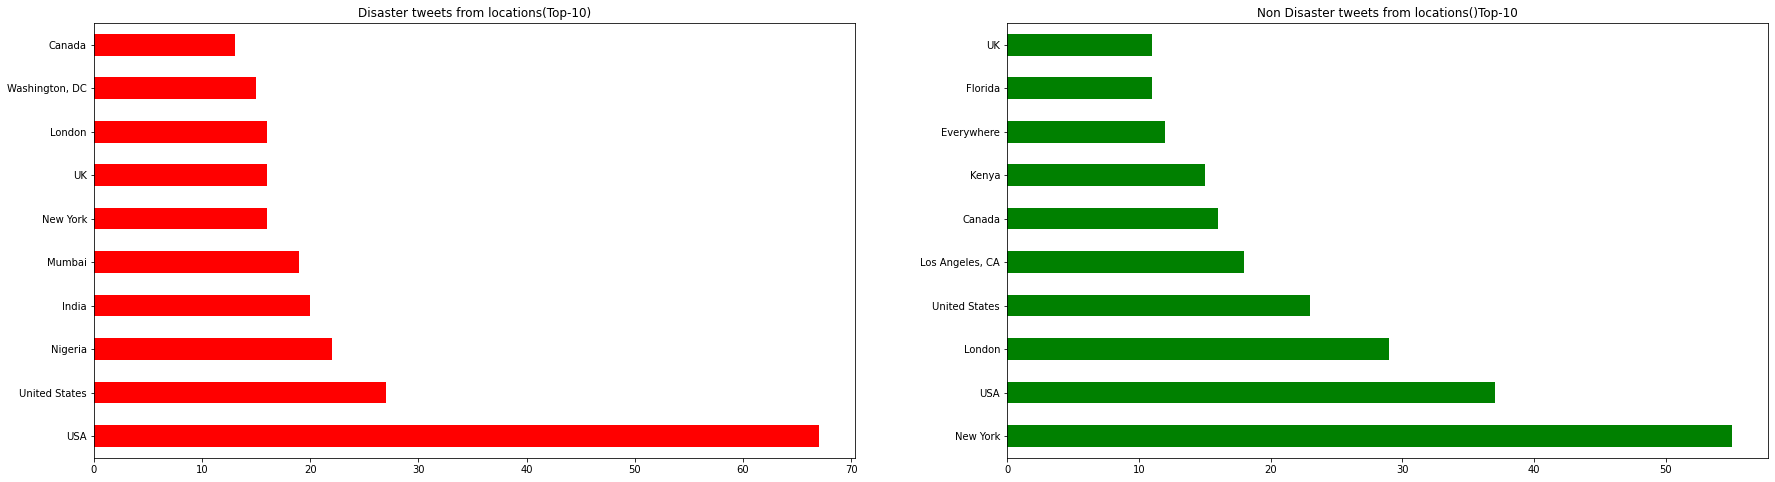

In [7]:
plt.figure(figsize=[30,8])

plt.subplot(121)

d_locations[:10].plot(kind='barh',color='Red')
plt.title('Disaster tweets from locations(Top-10)')

plt.subplot(122)
nd_locations[:10].plot(kind='barh',color='Green')
plt.title('Non Disaster tweets from locations()Top-10')

In [8]:
df_train=train_df[['text','target','class']]
df_train

,text,target,class
0,Our Deeds are the Reason of this #earthquake M...,1,Disaster
1,Forest fire near La Ronge Sask. Canada,1,Disaster
2,All residents asked to 'shelter in place' are ...,1,Disaster
3,"13,000 people receive #wildfires evacuation or...",1,Disaster
4,Just got sent this photo from Ruby #Alaska as ...,1,Disaster
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,Disaster
7609,@aria_ahrary @TheTawniest The out of control w...,1,Disaster
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,Disaster
7611,Police investigating after an e-bike collided ...,1,Disaster


### **Clean text**

In [9]:
import re
import string

In [10]:
def processTextR1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text=text.lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    return text

round1=lambda x: processTextR1(x)

df_train['clean_text']=df_train['text'].apply(round1)
test_df['clean_text']=test_df['text'].apply(round1)

df_train.head(6)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,text,target,class,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,Disaster,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,1,Disaster,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,Disaster,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,Disaster,people receive wildfires evacuation orders in...
4,Just got sent this photo from Ruby #Alaska as ...,1,Disaster,just got sent this photo from ruby alaska as s...
5,#RockyFire Update => California Hwy. 20 closed...,1,Disaster,rockyfire update california hwy closed in bo...


# **re library for replacement**

In [11]:
stri='ab23eedd qq e3d (33) [r] * . ?'
print('Original string:',stri)
print('Replace punctuation:',re.sub('[%s]' % re.escape(string.punctuation),'',stri))
print('Replace any match symbol:',re.sub('[.*#?]','',stri))
print('Replace words in square racket:',re.sub('\[.*?\]','',stri))
print('Replace words containing numbers:',re.sub('\w*\d\w*','',stri))

Original string: ab23eedd qq e3d (33) [r] * . ?
Replace punctuation: ab23eedd qq e3d 33 r   
Replace any match symbol: ab23eedd qq e3d (33) [r]   
Replace words in square racket: ab23eedd qq e3d (33)  * . ?
Replace words containing numbers:  qq  () [r] * . ?


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(max_features = 3000)

In [13]:
X=cv.fit_transform(df_train['clean_text']).toarray()
Y=df_train['target']
X_test =cv.transform(test_df['clean_text']).toarray()

In [14]:
print(X.shape,X_test.shape)

(7613, 3000) (3263, 3000)


# **Training**

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=0,test_size=0.2)

In [17]:
models={'RandomForestClassifier' : make_pipeline(RandomForestClassifier())}

In [18]:
fit_models={}
for algo, pipeline in models.items():
    model = pipeline.fit(x_train,y_train)
    fit_models[algo] =model
    


In [19]:
fit_models

{'RandomForestClassifier': Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])}

In [20]:
for model in fit_models:
    print(f"{model} : {fit_models[model].score(x_train,y_train)*100}%")

RandomForestClassifier : 98.32512315270935%


In [21]:
scores = {}
for model in fit_models:
    print(f"{model} : {fit_models[model].score(x_test,y_test)*100:.2f}%")
    scores[model]=fit_models[model].score(x_test,y_test)

RandomForestClassifier : 80.04%


In [22]:
predictions=fit_models["RandomForestClassifier"].predict(X_test)
predictions[:12]

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [23]:
sample_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [24]:
sample_df['target']=predictions
sample_df.target.value_counts()

0    2164
1    1099
Name: target, dtype: int64

In [25]:
sample_df.to_csv('Submission.csv',index=False)

In [26]:
sample_df

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
